<a href="https://colab.research.google.com/github/wesslen/llm-experiments/blob/main/notebooks/prompt_sensitivity/claude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prompt Sensitivity Experiment with DSPy and Claude

This notebook explores how small changes in prompts affect Claude's responses using DSPy. We'll test variations in spacing, punctuation, and minor wording changes to analyze the model's sensitivity to prompt formatting.

In [1]:
%%capture
!uv pip install --system dspy

In [3]:
import dspy
import pandas as pd
import numpy as np
from typing import List, Dict
import json
from datetime import datetime

from google.colab import userdata

# Configure DSPy with Claude
api_key = userdata.get('ANTHROPIC_API_KEY')
lm = dspy.LM('anthropic/claude-3-opus-20240229', api_key=api_key)
dspy.configure(lm=lm)

## Define Prompt Variations

We'll create a set of prompt variations to test different aspects of formatting sensitivity.

In [4]:
from typing import List, Dict, Union
import json
import pandas as pd
from datetime import datetime
import dspy
from difflib import SequenceMatcher
from IPython.display import HTML

class PromptTemplate(dspy.Signature):
    '''Template for generating responses to prompt variations'''
    context = dspy.InputField()
    prompt = dspy.InputField()
    response = dspy.OutputField()

class PromptExperiment:
    def __init__(self, base_prompt: str):
        self.base_prompt = base_prompt
        self.results = []

    def generate_variations(self) -> List[Dict]:
        '''Generate various prompt modifications'''
        variations = [
            # Original prompt
            {"type": "original", "prompt": self.base_prompt},

            # Extra spacing variations
            {"type": "extra_space_start", "prompt": f" {self.base_prompt}"},
            {"type": "extra_space_end", "prompt": f"{self.base_prompt} "},
            {"type": "double_space", "prompt": self.base_prompt.replace(" ", "  ")},

            # Punctuation variations
            {"type": "add_period", "prompt": f"{self.base_prompt}."},
            {"type": "add_question", "prompt": f"{self.base_prompt}?"},
            {"type": "add_exclamation", "prompt": f"{self.base_prompt}!"},

            # Capitalization variations
            {"type": "all_caps", "prompt": self.base_prompt.upper()},
            {"type": "all_lower", "prompt": self.base_prompt.lower()},

            # Word boundary variations
            {"type": "no_spaces", "prompt": self.base_prompt.replace(" ", "")},
            {"type": "extra_newline", "prompt": f"\n{self.base_prompt}\n"}
        ]
        return variations

    def run_experiment(self, context: str = ""):
        '''Run the experiment with all prompt variations'''
        variations = self.generate_variations()
        program = dspy.Predict(PromptTemplate)

        for var in variations:
            try:
                # Get response from Claude
                result = program(context=context, prompt=var["prompt"])

                # Store results
                self.results.append({
                    "variation_type": var["type"],
                    "prompt": var["prompt"],
                    "response": result.response,
                    "timestamp": datetime.now().isoformat()
                })
            except Exception as e:
                print(f"Error with variation {var['type']}: {str(e)}")

    def analyze_results(self) -> pd.DataFrame:
        '''Analyze the results of the experiment'''
        df = pd.DataFrame(self.results)

        # Add basic analytics
        df['response_length'] = df['response'].str.len()
        df['word_count'] = df['response'].str.split().str.len()

        # Calculate response similarity scores
        base_response = df[df['variation_type'] == 'original']['response'].iloc[0]

        return df

    def save_results(self, filename: str):
        '''Save results to JSON file'''
        with open(filename, 'w') as f:
            json.dump(self.results, f, indent=2)

    def _split_into_tokens(self, text: str) -> list:
        """Split text into tokens (words and spaces)."""
        return [token for token in text.replace('\n', ' \n ').split(' ') if token]

    def _create_diff_spans(self, a: list, b: list) -> tuple[list, list]:
        """Create HTML spans for diff visualization with proper spacing."""
        matcher = SequenceMatcher(None, a, b)
        old_spans = []
        new_spans = []

        def add_space_after_span(spans: list, is_last: bool = False):
            """Add space after span unless it's the last one or already ends with space"""
            if not is_last and not spans[-1].endswith(' </span>'):
                spans.append('<span> </span>')

        for idx, (tag, i1, i2, j1, j2) in enumerate(matcher.get_opcodes()):
            is_last = idx == len(matcher.get_opcodes()) - 1

            if tag == 'equal':
                span_text = ' '.join(a[i1:i2])
                old_spans.append(f'<span>{span_text}</span>')
                new_spans.append(f'<span>{span_text}</span>')
                add_space_after_span(old_spans, is_last)
                add_space_after_span(new_spans, is_last)

            elif tag == 'delete':
                span_text = ' '.join(a[i1:i2])
                old_spans.append(f'<span style="background-color: #ffdce0">{span_text}</span>')
                add_space_after_span(old_spans, is_last)

            elif tag == 'insert':
                span_text = ' '.join(b[j1:j2])
                new_spans.append(f'<span style="background-color: #cdffd8">{span_text}</span>')
                add_space_after_span(new_spans, is_last)

            elif tag == 'replace':
                old_span_text = ' '.join(a[i1:i2])
                new_span_text = ' '.join(b[j1:j2])
                old_spans.append(f'<span style="background-color: #ffdce0">{old_span_text}</span>')
                new_spans.append(f'<span style="background-color: #cdffd8">{new_span_text}</span>')
                add_space_after_span(old_spans, is_last)
                add_space_after_span(new_spans, is_last)

        return old_spans, new_spans

    def display_diff(self, modified_variation: Union[str, int], reference_variation: str = "original") -> HTML:
        """
        Generate an HTML visualization of the differences between two experiment variations.

        Args:
            modified_variation: Either the variation_type (str) or index (int) of the modified version
            reference_variation: variation_type of the reference version (default: "original")

        Returns:
            IPython.display.HTML: HTML-formatted diff visualization
        """
        # Find reference version
        reference_result = next(r for r in self.results if r["variation_type"] == reference_variation)

        # Find modified version
        if isinstance(modified_variation, str):
            modified_result = next(r for r in self.results if r["variation_type"] == modified_variation)
        else:  # modified_variation is an index
            modified_result = self.results[modified_variation]

        # Split responses into tokens
        old_tokens = self._split_into_tokens(reference_result["response"])
        new_tokens = self._split_into_tokens(modified_result["response"])

        # Generate diff spans
        old_spans, new_spans = self._create_diff_spans(old_tokens, new_tokens)

        # Create HTML output with prompts in titles
        html_output = f'''
        <div style="font-family: monospace; white-space: pre-wrap;">
            <div style="margin-bottom: 10px;">
                <div style="color: #666; margin-bottom: 3px;">- Original ({reference_result["variation_type"]}): {reference_result["prompt"]}</div>
                <div style="border: 1px solid #d0d7de; padding: 8px; border-radius: 4px;">
                    {''.join(old_spans)}
                </div>
            </div>
            <div>
                <div style="color: #666; margin-bottom: 3px;">+ Modified ({modified_result["variation_type"]}): {modified_result["prompt"]}</div>
                <div style="border: 1px solid #d0d7de; padding: 8px; border-radius: 4px;">
                    {''.join(new_spans)}
                </div>
            </div>
        </div>
        '''

        return HTML(html_output)

## Run Experiments

Let's test the prompt sensitivity with a few different base prompts.

In [5]:
# Test cases
test_cases = [
    {
        "prompt": "Explain how photosynthesis works",
        "context": "You are a biology teacher explaining concepts to high school students."
    },
    {
        "prompt": "Write a short poem about the moon",
        "context": "You are a creative writing instructor helping students with poetry."
    },
    {
        "prompt": "What are the key features of Python",
        "context": "You are a programming instructor teaching beginners about Python."
    },
    {
        "prompt": "Summarize",
        "context": "You are a research assistant helping to condense complex papers into key points."
    },
    {
        "prompt": "Explain the difference between mitochondrial DNA and nuclear DNA",
        "context": "You are a genetics researcher explaining concepts to undergraduate students."
    },
    {
        "prompt": "Design a database schema for a library management system",
        "context": "You are a database architect helping junior developers."
    },
    {
        "prompt": "Debug why my SELECT query with JOIN is slow",
        "context": "You are a SQL performance tuning expert helping optimize database queries."
    }
]

# Run experiments
experiments = []
for case in test_cases:
    experiment = PromptExperiment(case["prompt"])
    experiment.run_experiment(context=case["context"])
    experiments.append(experiment)

    # Save results
    experiment.save_results(f"results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")

## Exploration

In [6]:
from typing import List, Union, Optional
from IPython.display import display, HTML

def display_experiment_diffs(
    experiments: List[PromptExperiment],
    experiment_idx: Optional[Union[int, List[int]]] = None,
    variation_type: str = "extra_space_start",
    reference_variation: str = "original"
) -> None:
    """
    Display diffs for one or more experiments.

    Args:
        experiments: List of PromptExperiment objects
        experiment_idx: Index or list of indices of experiments to display (None for all)
        variation_type: The variation type to compare against the reference
        reference_variation: The reference variation type (default: "original")
    """
    # Convert single index to list for consistent handling
    if isinstance(experiment_idx, int):
        experiment_idx = [experiment_idx]

    # If no index specified, show all experiments
    if experiment_idx is None:
        experiment_idx = range(len(experiments))

    for idx in experiment_idx:
        experiment = experiments[idx]

        # Display experiment identifier
        display(HTML(f'''
        <div style="margin: 20px 0; padding: 10px; background-color: #f6f8fa; border-radius: 4px;">
            <strong>Experiment {idx}</strong><br>
            Base Prompt: {experiment.base_prompt}
        </div>
        '''))

        # Display the diff
        display(experiment.display_diff(variation_type, reference_variation))

In [7]:
# Example usage:
# Show diff for a single experiment
display_experiment_diffs(experiments, experiment_idx=0, variation_type="extra_space_start")


In [8]:
# Show diffs for specific experiments
display_experiment_diffs(experiments, experiment_idx=[0, 2], variation_type="all_caps")

In [9]:
# Show diffs for all experiments
display_experiment_diffs(experiments, variation_type="double_space")

In [10]:
# You can also create a comparison matrix for a specific experiment
def display_variation_matrix(
    experiment: PromptExperiment,
    variations: Optional[List[str]] = None
) -> None:
    """
    Display a matrix of diffs between selected variations for a single experiment.

    Args:
        experiment: PromptExperiment object to analyze
        variations: List of variation types to compare (None for all available)
    """
    # If no variations specified, get all unique variation types
    if variations is None:
        variations = list(set(r["variation_type"] for r in experiment.results))

    # Display matrix header
    display(HTML(f'''
    <div style="margin: 20px 0; padding: 10px; background-color: #f6f8fa; border-radius: 4px;">
        <strong>Variation Matrix</strong><br>
        Base Prompt: {experiment.base_prompt}<br>
        Comparing variations: {", ".join(variations)}
    </div>
    '''))

    # Display diffs for each variation
    for var_type in variations:
        if var_type != "original":  # Skip comparing original to itself
            display(experiment.display_diff(var_type))

In [11]:
# Example usage:
# Show all variations for experiment 1
display_variation_matrix(experiments[1])

In [12]:
# Show specific variations for experiment 1
display_variation_matrix(
    experiments[0],
    variations=["extra_space_start", "all_caps", "add_period"]
)

## Analyze Results

Now let's analyze the results to understand how different prompt variations affected the responses.

=== Response Length Statistics ===
               count         mean         std     min     25%     50%     75%  \
experiment_id                                                                   
0               11.0  1273.363636  125.496034  1097.0  1182.0  1246.0  1378.5   
1               11.0   323.181818  183.447986   191.0   247.5   251.0   262.0   
2               11.0  1439.090909  107.272042  1299.0  1380.5  1410.0  1488.5   
3               11.0  1200.454545  240.512937   517.0  1233.5  1269.0  1277.0   
4               11.0  1338.181818  122.780958  1204.0  1234.0  1319.0  1408.5   
5               11.0  1660.909091  232.099743  1319.0  1514.0  1666.0  1764.5   
6               11.0  1514.272727  275.374687   869.0  1410.5  1546.0  1666.5   

                  max  
experiment_id          
0              1462.0  
1               703.0  
2              1687.0  
3              1424.0  
4              1588.0  
5              2144.0  
6              1926.0  

=== Word Count Sta

<Figure size 1200x600 with 0 Axes>

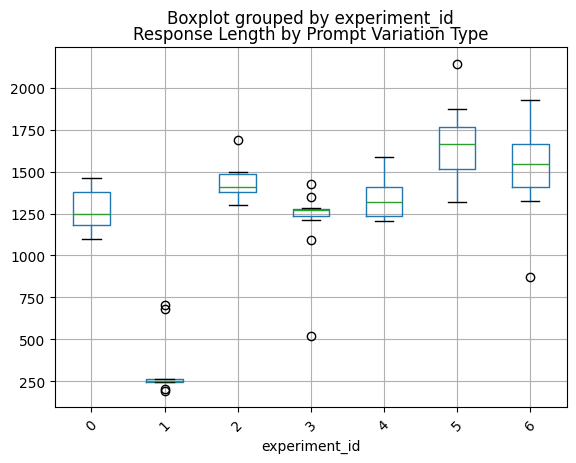

In [13]:
def analyze_experiment_results(experiments: List[PromptExperiment]):
    '''Analyze results across all experiments'''
    all_results = pd.concat([exp.analyze_results().assign(experiment_id=i) for i, exp in enumerate(experiments)])

    # Basic statistics
    print("=== Response Length Statistics ===")
    print(all_results.groupby('experiment_id')['response_length'].describe())

    print("\n=== Word Count Statistics ===")
    print(all_results.groupby('experiment_id')['word_count'].describe())

    # Visualization
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    all_results.boxplot(column='response_length', by='experiment_id', rot=45)
    plt.title('Response Length by Prompt Variation Type')
    plt.show()

    return all_results

# Analyze results
results_df = analyze_experiment_results(experiments)